In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from data.yahoo_finance_data import download_finance_data
from dateutil.relativedelta import relativedelta
from data.pre_processing import PreProcessing
from model.time2vec_transformer_model import Time2VecTransformer
from model.train_evaluate_model_helper import *

Tensorflow version: 2.3.1


Transformer models,a long with their amazing success in NLP have also shown great promise in time series forecast.

A transformer model with time embeddings to enable the model to learn periodic and non-periodic patterns will be implemented here as this combined with the self-attention mechanism should enable it to learn patterns from the financial history and forecast the future.

## Hyperparameters

In [3]:
# the Transformer model rqequired several hyperparameters

# sequence length to predict a value. The data set is in days so setting seq_len to 14 means the model will attempt to learn patterns from a 14 day period
seq_len = 14

# parameters to set the size of key, value, head and feed forward parts of the self attention mechanism
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

# training parameters, epochs = how many times through the data set as a whole, batch size set when to update the gradient
epochs = 40
batch_size = 32

In [4]:
def download_data():
    """
    Convenience function to download the last 700 days of data from Yahoo finance for BTC-GBP
    """
    to_date = datetime.now()
    from_date = to_date - relativedelta(days=700)
    
    return PreProcessing('BTC-GBP',download_finance_data(['BTC-GBP'],from_date,to_date))

# Test 1: Percentage daily change

Prepare a data set of features using only the 5 percentage change price figures

In [5]:
data = download_data()
data.calculate_normalised_percentage_change()

In [6]:
tvt = Time2VecTransformer('pctg_change',seq_len,d_k,d_v,n_heads,ff_dim,5)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 14, 2)        56          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 7)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 14, 7)        99114       concatenate[0][0]     

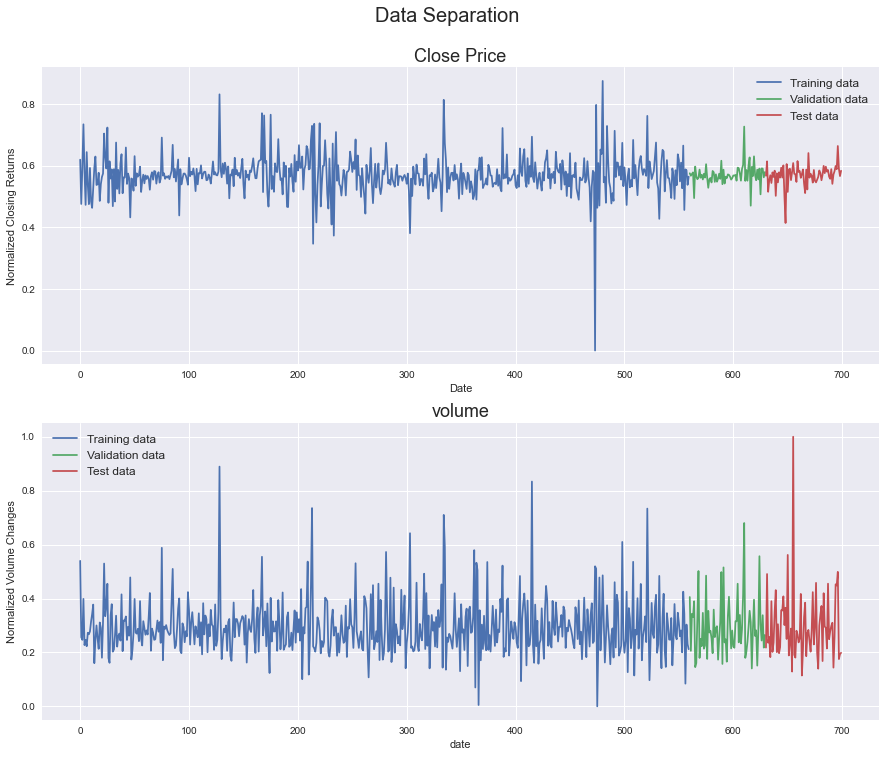

-------------------------------
Fitting model: pctg_change
-------------------------------
Epoch 1/40
17/18 [===========================>..] - ETA: 0s - loss: 0.2490 - mae: 0.4920 - mape: 284055.9375
Epoch 00001: val_loss improved from inf to 0.13400, saving model to pctg_change.hdf5
18/18 [==============================] - 4s 242ms/step - loss: 0.2486 - mae: 0.4915 - mape: 283015.6875 - val_loss: 0.1340 - val_mae: 0.3645 - val_mape: 63.6726
Epoch 2/40
17/18 [===========================>..] - ETA: 0s - loss: 0.0594 - mae: 0.2162 - mape: 481818.7188
Epoch 00002: val_loss improved from 0.13400 to 0.00124, saving model to pctg_change.hdf5
18/18 [==============================] - 1s 67ms/step - loss: 0.0591 - mae: 0.2157 - mape: 480053.8750 - val_loss: 0.0012 - val_mae: 0.0226 - val_mape: 3.8564
Epoch 3/40
17/18 [===========================>..] - ETA: 0s - loss: 0.0075 - mae: 0.0646 - mape: 1180257.7500
Epoch 00003: val_loss improved from 0.00124 to 0.00117, saving model to pctg_change.hdf

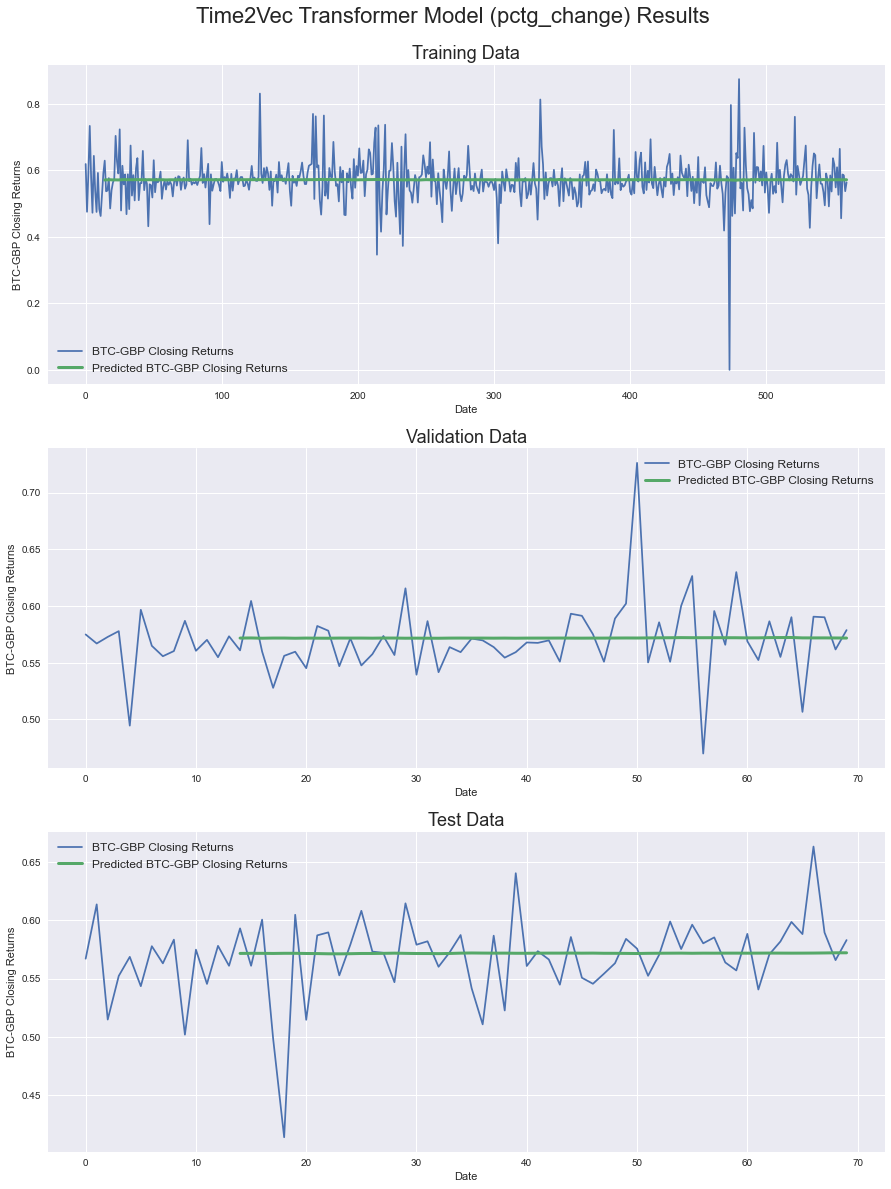

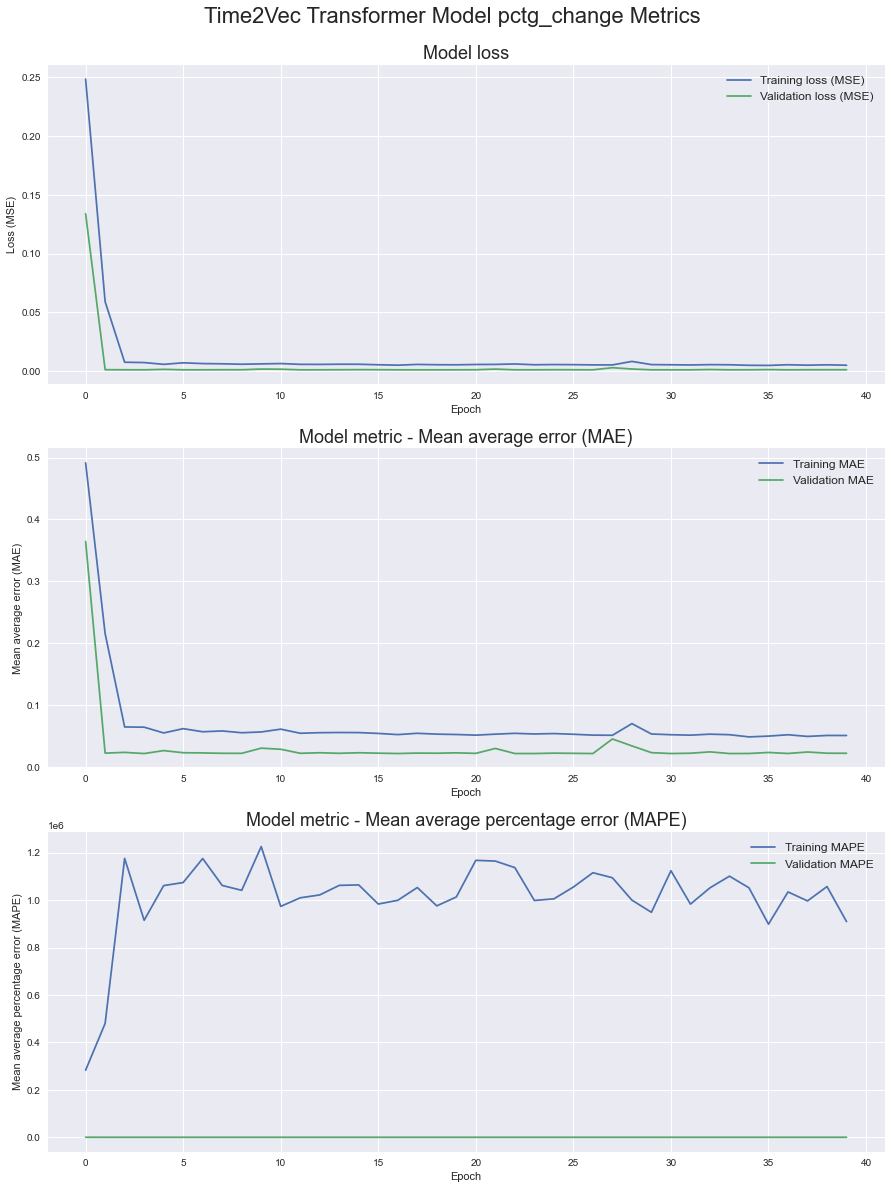

In [7]:
split_train_evalute_model(data,tvt,epochs,batch_size)

# Test 2: Moving Average

Prepare a data set of features using only the 5 percentage change in price figures and a 7 daily moving average

In [8]:
data = download_data()

In [9]:
data.apply_n_day_rolling_average(7)\
.calculate_normalised_percentage_change()

In [10]:
tvt = Time2VecTransformer('pctg_change_7d_ma',seq_len,d_k,d_v,n_heads,ff_dim,5)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 14, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector_2 (Time2Vector)    (None, 14, 2)        56          input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 14, 7)        0           input_2[0][0]                    
                                                                 time2_vector_2[0][0]             
__________________________________________________________________________________________________
transformer_encoder_6 (Transfor (None, 14, 7)        99114       concatenate_1[0][0]   

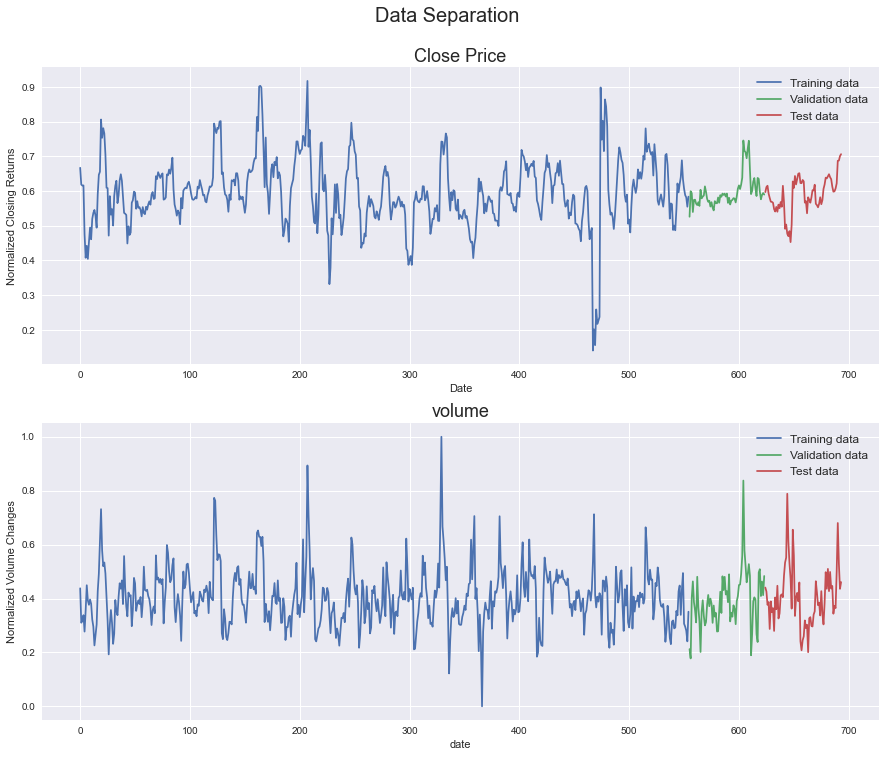

-------------------------------
Fitting model: pctg_change_7d_ma
-------------------------------
Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 0.2978 - mae: 0.5354 - mape: 89.5255
Epoch 00001: val_loss improved from inf to 0.20608, saving model to pctg_change_7d_ma.hdf5
17/17 [==============================] - 4s 254ms/step - loss: 0.2978 - mae: 0.5354 - mape: 89.5255 - val_loss: 0.2061 - val_mae: 0.4514 - val_mape: 74.5829
Epoch 2/40
16/17 [===========================>..] - ETA: 0s - loss: 0.1204 - mae: 0.3250 - mape: 53.6489
Epoch 00002: val_loss improved from 0.20608 to 0.02305, saving model to pctg_change_7d_ma.hdf5
17/17 [==============================] - 1s 71ms/step - loss: 0.1161 - mae: 0.3164 - mape: 52.1251 - val_loss: 0.0231 - val_mae: 0.1441 - val_mape: 23.4204
Epoch 3/40
16/17 [===========================>..] - ETA: 0s - loss: 0.0166 - mae: 0.0986 - mape: 18.0902
Epoch 00003: val_loss improved from 0.02305 to 0.00435, saving model to pctg_change_7d_ma

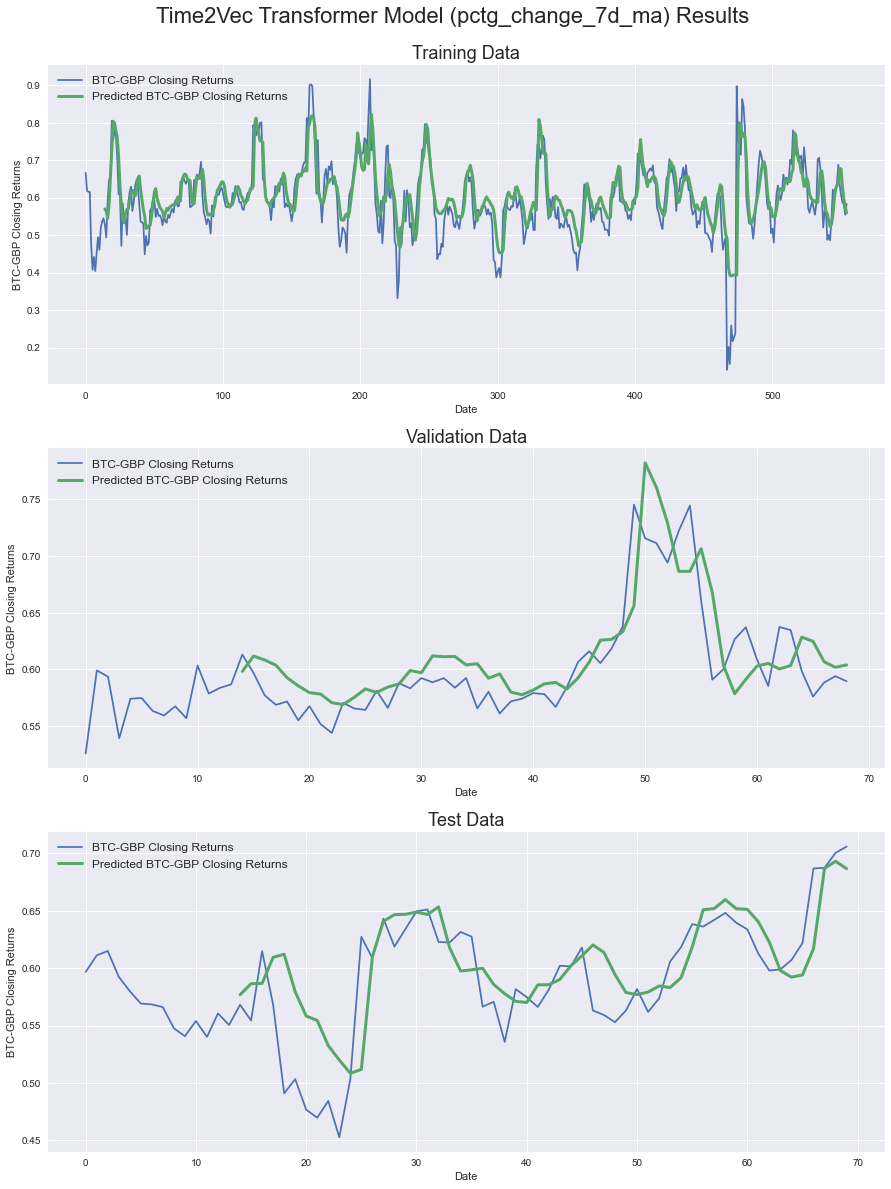

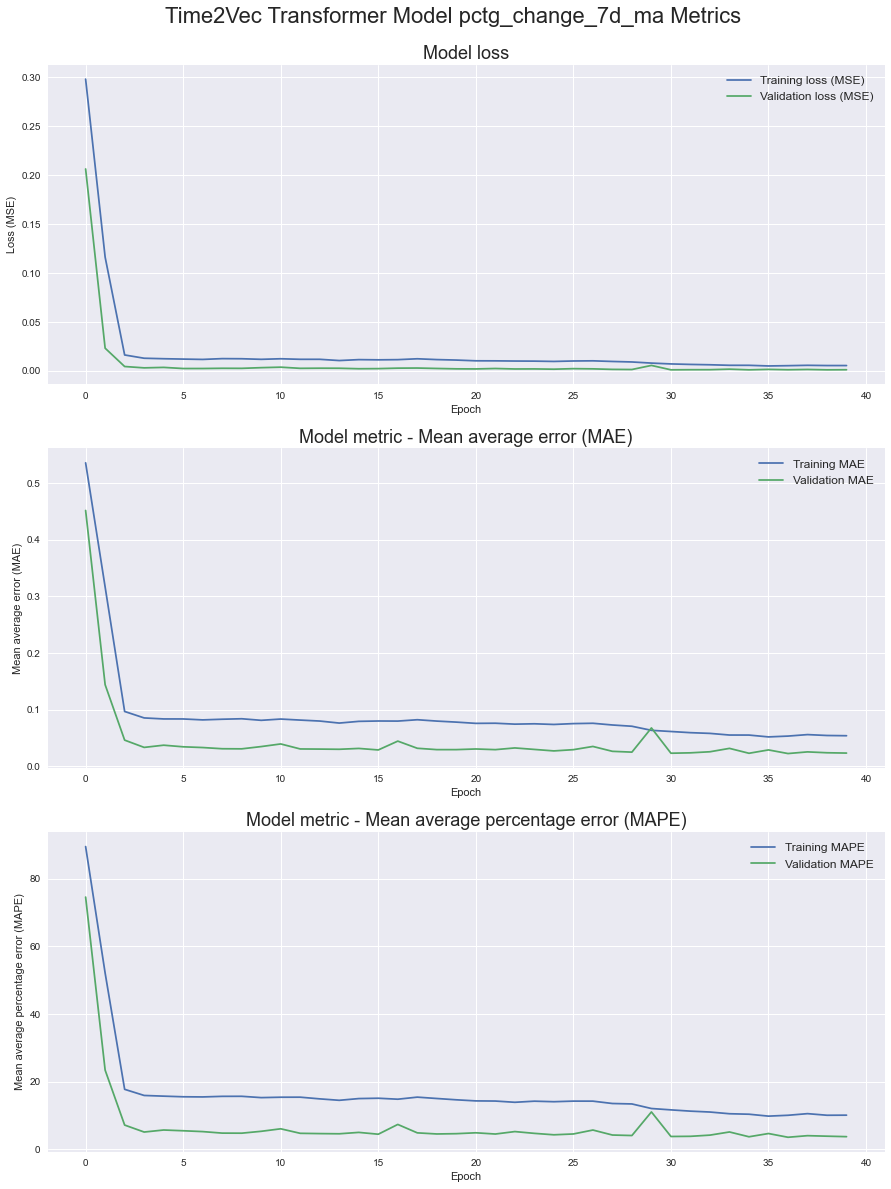

In [11]:
split_train_evalute_model(data,tvt,epochs,batch_size)

# Test 3: Exponentially Weighted Moving Average

Prepare a data set of features using only the 5 percentage change in price figures and a 7 daily exponentially weighted moving average

In [12]:
data = download_data()

In [13]:
data.apply_n_day_exp_weighted_mean(7)\
.calculate_normalised_percentage_change()

In [14]:
tvt = Time2VecTransformer('pctg_change_7d_ewm',seq_len,d_k,d_v,n_heads,ff_dim,5)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 14, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector_4 (Time2Vector)    (None, 14, 2)        56          input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 14, 7)        0           input_3[0][0]                    
                                                                 time2_vector_4[0][0]             
__________________________________________________________________________________________________
transformer_encoder_12 (Transfo (None, 14, 7)        99114       concatenate_2[0][0]   

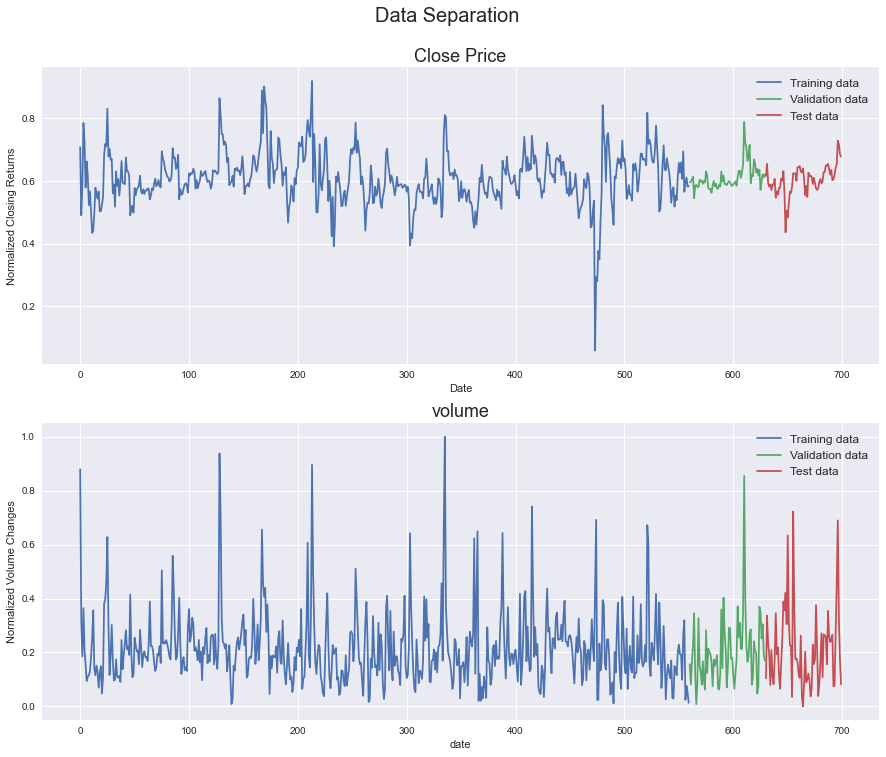

-------------------------------
Fitting model: pctg_change_7d_ewm
-------------------------------
Epoch 1/40
17/18 [===========================>..] - ETA: 0s - loss: 0.2999 - mae: 0.5395 - mape: 88.3565
Epoch 00001: val_loss improved from inf to 0.18610, saving model to pctg_change_7d_ewm.hdf5
18/18 [==============================] - 4s 248ms/step - loss: 0.2994 - mae: 0.5389 - mape: 88.2861 - val_loss: 0.1861 - val_mae: 0.4293 - val_mape: 69.5861
Epoch 2/40
17/18 [===========================>..] - ETA: 0s - loss: 0.0970 - mae: 0.2845 - mape: 46.3759
Epoch 00002: val_loss improved from 0.18610 to 0.00925, saving model to pctg_change_7d_ewm.hdf5
18/18 [==============================] - 1s 67ms/step - loss: 0.0967 - mae: 0.2840 - mape: 46.2878 - val_loss: 0.0093 - val_mae: 0.0863 - val_mape: 13.6553
Epoch 3/40
17/18 [===========================>..] - ETA: 0s - loss: 0.0112 - mae: 0.0799 - mape: 14.8845
Epoch 00003: val_loss improved from 0.00925 to 0.00233, saving model to pctg_change_7d

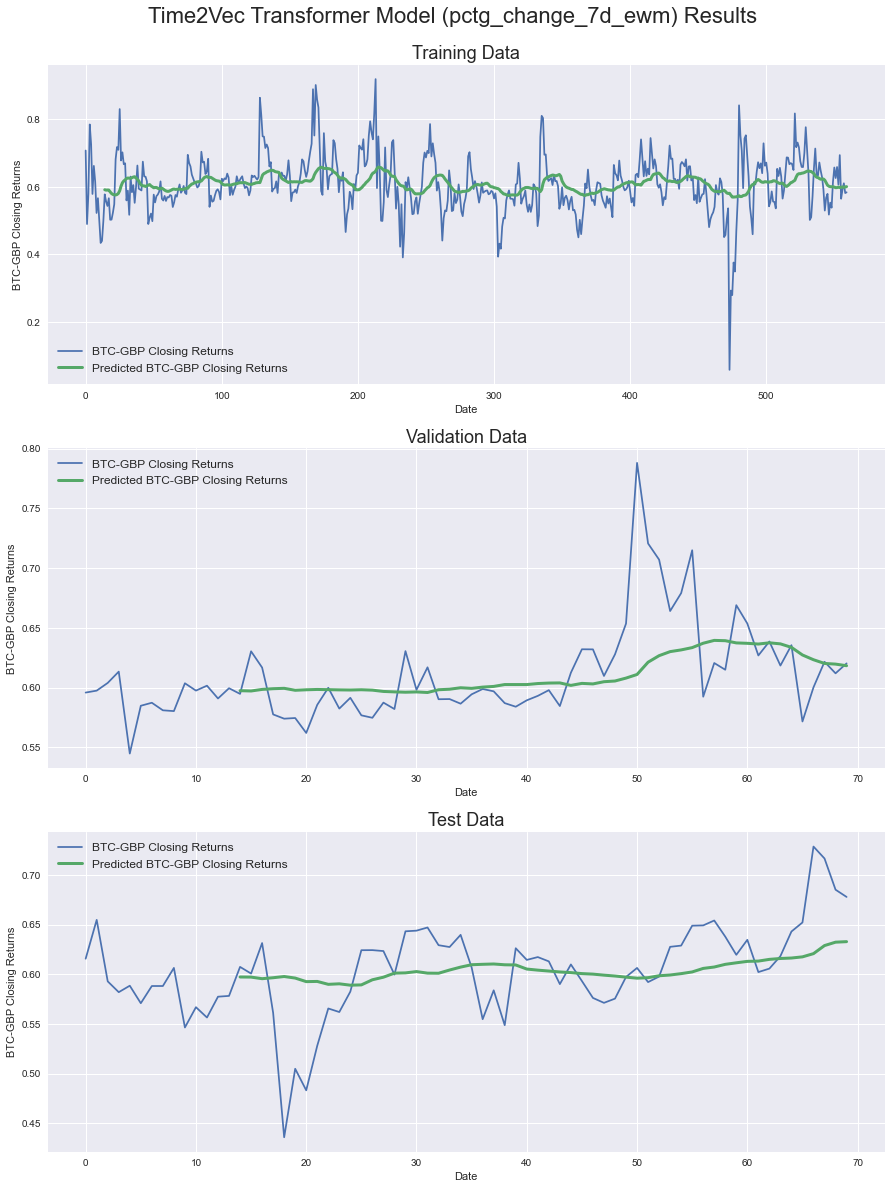

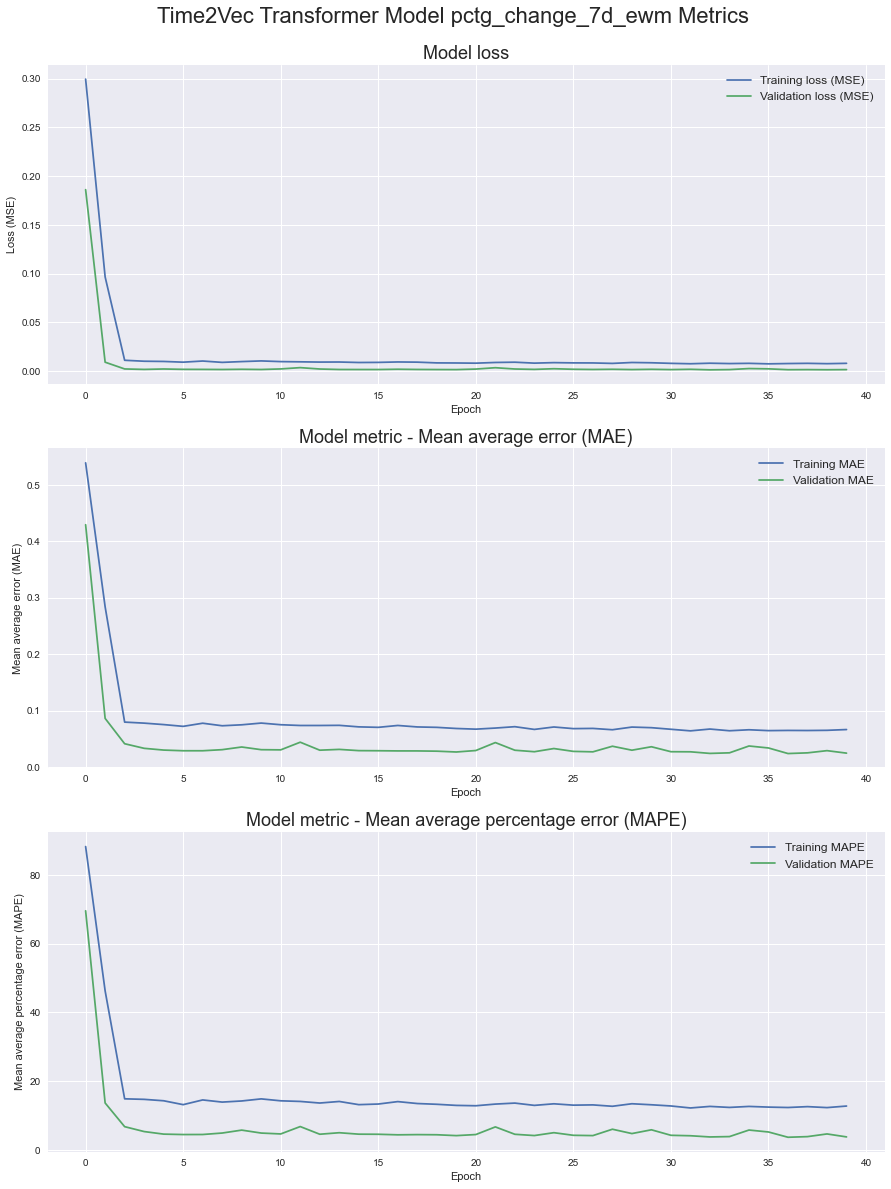

In [15]:
split_train_evalute_model(data,tvt,epochs,batch_size)

# Test 4: 7 Day Moving Average Tuning

Prepare a data set of features using only the 5 percentage change in price figures and a 7 day moving average. Increase the dimensions of key and value to boost trainable parameters in the model up to 1.1m.

In [16]:
seq_len = 14

d_k = 512
d_v = 512
n_heads = 24
ff_dim = 512

epochs = 40
batch_size = 32

In [17]:
data = download_data()

In [18]:
data.apply_n_day_rolling_average(7)\
.calculate_normalised_percentage_change()

In [19]:
tvt = Time2VecTransformer('pctg_change_7d_ma_1.1m_params',seq_len,d_k,d_v,n_heads,ff_dim,5)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 14, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector_6 (Time2Vector)    (None, 14, 2)        56          input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 14, 7)        0           input_4[0][0]                    
                                                                 time2_vector_6[0][0]             
__________________________________________________________________________________________________
transformer_encoder_18 (Transfo (None, 14, 7)        388650      concatenate_3[0][0]   

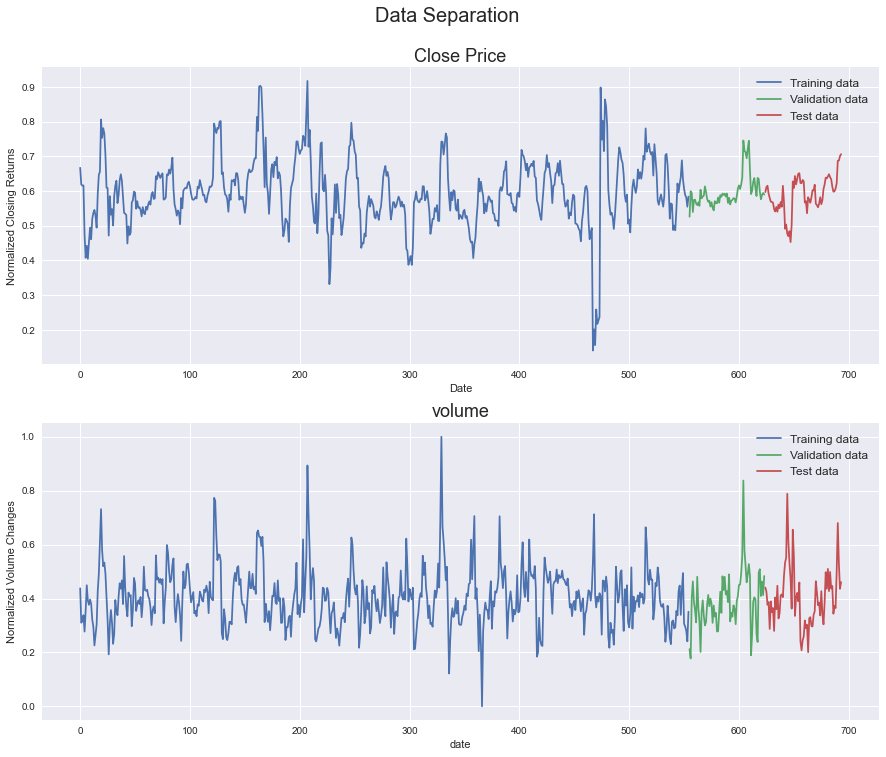

-------------------------------
Fitting model: pctg_change_7d_ma_1.1m_params
-------------------------------
Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 0.2793 - mae: 0.5168 - mape: 86.1903
Epoch 00001: val_loss improved from inf to 0.16996, saving model to pctg_change_7d_ma_1.1m_params.hdf5
17/17 [==============================] - 10s 603ms/step - loss: 0.2793 - mae: 0.5168 - mape: 86.1903 - val_loss: 0.1700 - val_mae: 0.4095 - val_mape: 67.5985
Epoch 2/40
17/17 [==============================] - ETA: 0s - loss: 0.0847 - mae: 0.2595 - mape: 42.5419
Epoch 00002: val_loss improved from 0.16996 to 0.00757, saving model to pctg_change_7d_ma_1.1m_params.hdf5
17/17 [==============================] - 4s 228ms/step - loss: 0.0847 - mae: 0.2595 - mape: 42.5419 - val_loss: 0.0076 - val_mae: 0.0727 - val_mape: 11.5332
Epoch 3/40
17/17 [==============================] - ETA: 0s - loss: 0.0140 - mae: 0.0910 - mape: 17.1007
Epoch 00003: val_loss improved from 0.00757 to 0.00

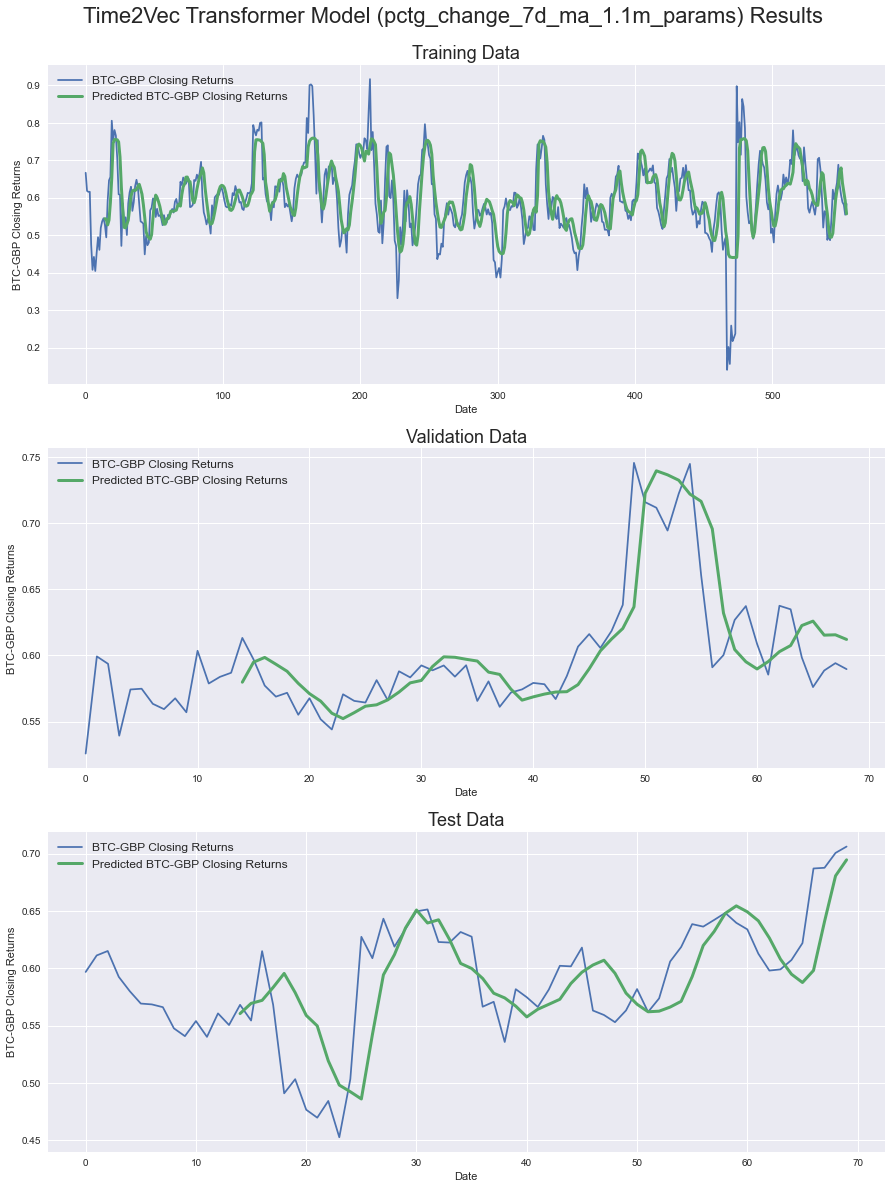

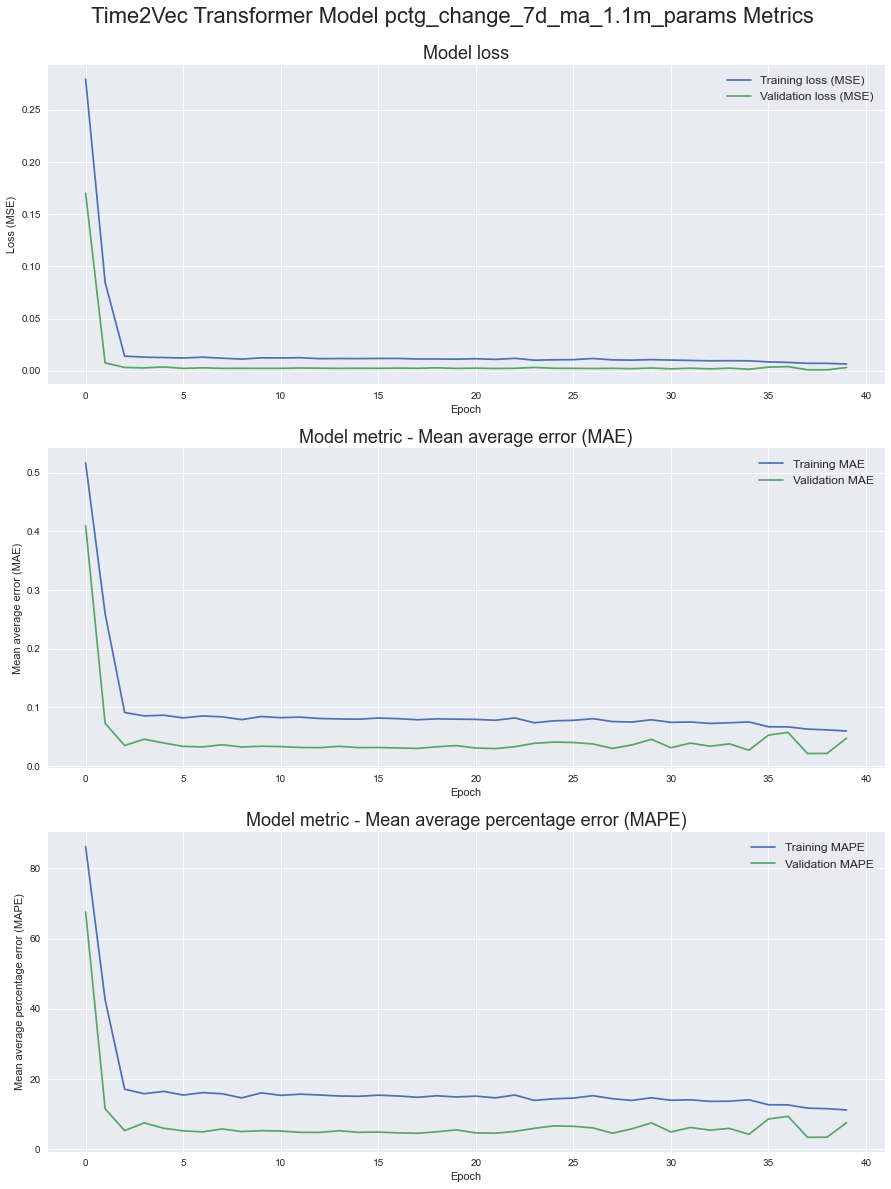

In [20]:
split_train_evalute_model(data,tvt,epochs,batch_size)